# Reading K-Coefficients in npy Files

## TASK: figure out how everything in the files worked.

### Well I've mostly done that. 

This notebook goes over the files provided by Paul Corlies. There are two major sections:

1) The Data Files

2) The Calculation Functions

Item 1) holds the actual k-coefficients (and a lot more) in the .npy files that are a bit hard to wrap one's head around. Item 2) is just a demonstration of how optical depth is calculated from the data in the files. This actually isn't too hard to see once it's laid out, but when it's not laid out it can be quite difficult. So let's get right to it.

# I - The Data Files

## Unfortunately, it does not fly, nor does it have flies.

In short:

- .npy file is a map with sub-maps of varying types

- contains all k-coefficients, temperatures, pressures, wavelengths, and gauss orders necessary

- data accessed through numpy easliy through array/dictionary formalism

- coding a python script to make a .csv for our code would be easy

- .npy file contains log of its own creation and the code used to create it. Bonus!

In not-as-short but still not very long:

The data files are .npy files. Simply opening them in numpy and displaying them doesn't really illucidate what's in them.

In [68]:
import numpy as np
data = np.load('kc_12CH4.VIMS_2004.v01.npy', allow_pickle=True).item()
print(data)

#This block is left un-run for the github version, since printing this file floods the github display.

However, it is possible to access each individual part of this file one at a time. It's surprisingly comprehensive in what it contains, but there's a lot of it. So instead of trying to piece it together from individual parts of the flie one line of code at a time, here's a flow chart.

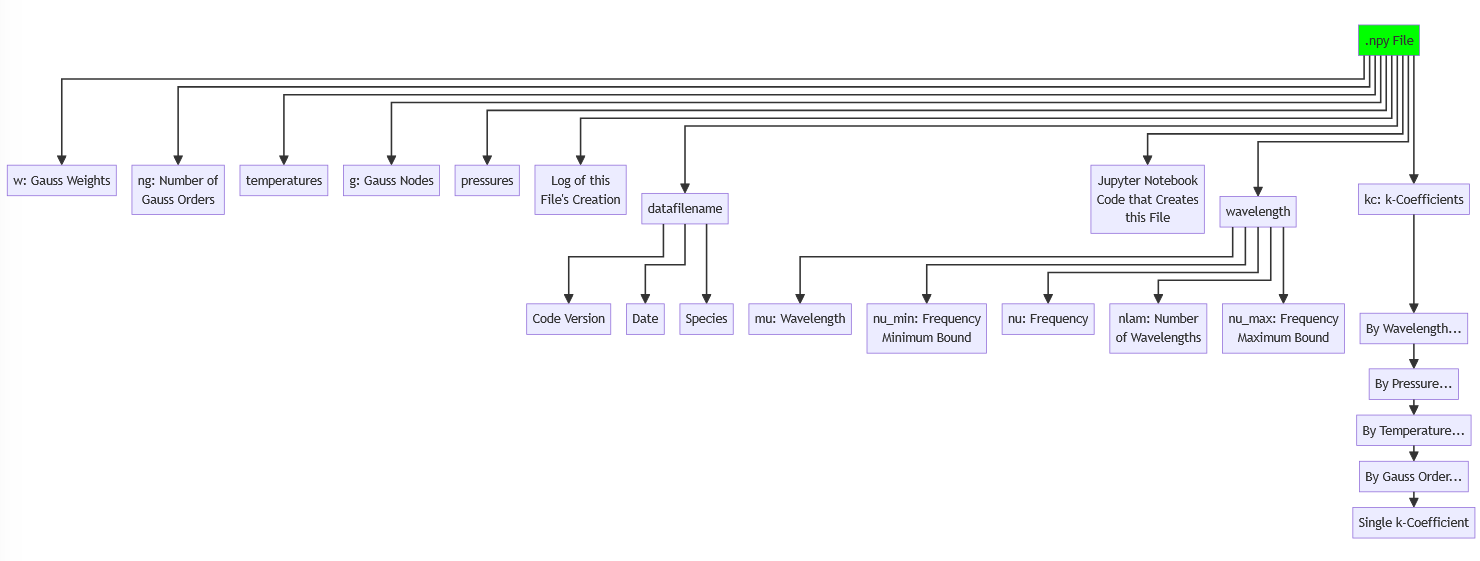

The .npy file is stored much like a dictionary/map, except that this dictionary has sub dictionaries and holds all manner of things it seemingly any form. The contents range from single numbers to an entire jupyter notebook file stored line by line. Fun. 

Each item at the file's highest level has a name. Some of these are really simple: "g", "w", and "ng" are all related to the gauss orders associated with the k-coefficients. "g" is the gauss nodes (positions), a single array containing their values. "w" contains the gauss weights. Meanwhile "ng" is a single number that tells everyone how big "g" and "w" need to be. (It's 10 in our file's example). 

The "temperatures" and "pressures" options are also arrays of numbers. "temperatures" is in Kelvin and has 11 values, while "pressures" is in mbar and has 40 values. "datafilename" is just a string that stores the file's name, but that name includes some important data not found elsewhere, like the gas species, the year generated, and the version of the code it was generated on. 

"wavelength" might be similar to "temperatures" and "pressures" in theory, but in practice it itself is a dictionary mch like the .npy file itself. "wavelength" includes "nlam", "nu", "mu", "nu_max", "nu_min". "nlam" is just a number that stores how many wavelengths there are. "nu" is the frequency and "mu" is the wavelength as it should be measured, in *length*. Incidentially it is measured in microns, um, and ranges from below 1 to just above 5 microns. 

The "nu_max" and "nu_min" are a little strange, as as far as I can tell they can be combined into one array and share the same purpose, as all of their values except the edge values are repeated. They are placing "bounds" on the frequency values, essentially bins that tell code which values map to which wavelengths. Except the upper bound for one value matches the lower bound for another value, so why not just make it one array? For whatever reason, both are recorded here. 

The last major item in the .npy file is "kc", which holds the k-Coefficients. They are stored by their wavelength, pressure, temperature, and gauss order. Four dimensions of input required just to get a single k coefficient. 

There are two *unusual* parts of the .npy file. "logfile" contains a bunch of strings that are literally console logs of what happened when the file itself was created. The "notebook" item is a complete Jupyter Notebook file hidden within this file. It can be extracted and run, though I personally had to replace all the tab characters with the equivalent spaces for the effect to work. The notebook itself isn't able to run as it relies on file structures not present on this machine, but the code that constructs the k-coefficients can be explored if desired. (For our purposes, we don't need to generate them, we just need to use them, so further investigation is not strictly necessary). 

Now, how do we access these values, particuarly the k-coefficients? Well, we treat the data object we created by reading the file as a dictionary/map, and then we keep delving. Examples are as follows:

In [67]:
import numpy as np
data = np.load('kc_12CH4.VIMS_2004.v01.npy', allow_pickle=True).item() 

#Accessing the number of gauss orders, or any individual value. 
print("Number of Gauss Orders: ",data["ng"])

#Accessing a temperature, or any array value.
print("Temperature Number 10: ",data["temperatures"][9])

#Getting information from wavelength can be a bit esoteric. 
print("Wavelength index 200 in both frequency and wavelength: ", 
      data["wavelength"]["nu"][200], data["wavelength"]["mu"][200])

#Demonstration that the upper and lower bounds do match for wavelength
print("Upper and Lower Bound Matching For Wavelength: ",
      data["wavelength"]["nu_max"][202], data["wavelength"]["nu_min"][201])
#The indices may look backward, but that's because the max and min values are in frequency.
#While everything is ordered by actual wavelength. 

#Accessing k-coefficient values:
print("k-coefficient (1,1,1,1): ",data["kc"][1][1][1][1])

#If you wanted to get a line from one of the files, you can, though not sure why you would want to. 
print("Log Second Line: ", data["logfile"][1])



Number of Gauss Orders:  10
Temperature Number 10:  196.0
Wavelength index 200 in both frequency and wavelength:  2381.4968 4.19904
Upper and Lower Bound Matching For Wavelength:  2367.336065111134 2367.336065111134
k-coefficient (1,1,1,1):  5.098681515867682e-05
Log Second Line:  12CH4 k-coefficient calculation version 01 -



With that you should be able to extract everything you might need from the file. However, one type of extraction is mostly done for us already, and that's what the next section is about, not that we could use it in C++. 

Speaking of C++, it won't be able to read the .npy file readily. Fortunately, a simple python script can turn the entire thing into a .csv file easily. I would recommend ignoring the "logfile" and "notebook" section as the information stored within is entirely useless for doing calculations (but it is very nice from a documentaiton point of view). 

**Optional Considerations**: We can remove the number of gauss orders and infer it from the length of "g" and "w". We could also add data stored in the title to the file so it could easily be accessed without scrubbing strings. Lastly, the "nu_max" and "nu_min" are redundant, they could be combined into one array the size of one of them +1 entry.

# II - The Calculation Functions

## Data by itself is useless!

In short:

- Three functions act as one

- Take in k-coefficients, spit out calculated optical depths at every atmosphere layer

- Primary step is linear interpolation in 2D log space

- Cannot be used directly, relies on structure of "model". Implementaiton would still be simple.

In not-as-short but still pretty short:

The following code was given to us with the data files. Below it I do a brief analysis, but it's not that complicated.

```
def set_species(model, species, kc_file, CH3D_scale=None, verbose=False):
     """Set methane opacities in atmosphere structure, model, by
     interpolatating k-coefficents from the specied kc_file,
     using the temperatures and pressures for each layer.
     """

     if CH3D_scale:
         if len(kc_file) != 2:
             print('two k-coefficient files needed for set_species()')
             return None

         #Need to replace NaNs before summing
         kc = np.load(kc_file[0],allow_pickle=True).item()
         kc['kc'][np.isnan(kc['kc'])]=0
         kc_CH3D = np.load(kc_file[1],allow_pickle=True).item()
         kc_CH3D['kc'][np.isnan(kc_CH3D['kc'])]=0
         kc['kc'] = kc['kc']+CH3D_scale*kc_CH3D['kc']

         model.update({'wavelength':kc['wavelength']['mu'],
                     'nlam':kc['wavelength']['nlam'], })
         append_kc_to_layers(model, kc, 'CH4')
         tau_CH4 = model['layers']['kc']['CH4'] * np.reshape(model['layers']['N_CH4'],
                                                            (model['nlay'],1,1))

         tau_CH4[np.isnan(tau_CH4)]=0
         if 'tau' not in model['layers']: model['layers'].update({'tau':{}})
         model['layers']['tau'].update({'CH4':tau_CH4})
         return

     if kc_file.endswith('.npy'):
         kc = np.load(kc_file,allow_pickle=True).item()
         model.update({'wavelength':kc['wavelength']['mu'],
                     'nlam':kc['wavelength']['nlam'], })
         append_kc_to_layers(model, kc, species)
         tau_species = model['layers']['kc'][species] * np.reshape(model['layers']['N_'+species],
                                                            (model['nlay'],1,1))

         tau_species[np.isnan(tau_species)]=0
         if 'tau' not in model['layers']: model['layers'].update({'tau':{}})
         model['layers']['tau'].update({species:tau_species})
         return

     if kc_file.endswith('.fits'):
         from astropy.io import fits
         hdu = fits.open(kc_file)

         kc = {'kc': hdu[0].data,
               'pressures':hdu[2].data['pressures'],
               'temperatures':hdu[3].data['temperatures'],
               'g': hdu[4].data['g'],
               'w': hdu[5].data['w'],
               'ng': hdu[0].header['NG'],
               }
         model.update({'wavelength':hdu[1].data['wavelength'],
                       'nlam':len(hdu[1].data['wavelength']),
                       })

         hdu.close()
         append_kc_to_layers(model, kc, species)
         tau_species = model['layers']['kc'][species] * np.reshape(model['layers']['N_'+species],
                                                            (model['nlay'],1,1))

         tau_species[np.isnan(tau_species)]=0
         if 'tau' not in model['layers']: model['layers'].update({'tau':{}})
         model['layers']['tau'].update({species:tau_species})

     return

def interpolate_kc(p, T, kc, verbose=False):
     """Linearly interpolate k-coefficients at a particular
     pressure and temperature, using the input k-coefficent grid, kc.
     The standard structure of k-coefficient data array is:

         [wavelengths,pressures,temperatures,g-nodes]

     where the g-node are the Legendre-Gauss quadrature nodes
     or "g-ordinate". Returned array of coefficients corresponds to:

         [wavelengths,g-nodes]
     """

     pressures = np.array(kc['pressures'])
     temperatures = np.array(kc['temperatures'])

     ind_p = np.where(pressures < p)
     ind_T = np.where(temperatures < T)

     i = (np.max(ind_p) if np.size(ind_p) else np.array(0)).clip(0,len(pressures)-2)
     j = (np.max(ind_T) if np.size(ind_T) else np.array(0)).clip(0,len(temperatures)-2)

     L11 = np.log(kc['kc'][:,i,j,:])
     L12 = np.log(kc['kc'][:,i+1,j,:])
     L21 = np.log(kc['kc'][:,i,j+1,:])
     L22 = np.log(kc['kc'][:,i+1,j+1,:])

     L1T = L11 + (L12-L11)*(T-temperatures[j])/(temperatures[j+1]-temperatures[j])
     L2T = L21 + (L22-L21)*(T-temperatures[j])/(temperatures[j+1]-temperatures[j])
     LPT = L1T + (L2T-L1T)*((np.log(p)-np.log(pressures[i]))/
                            (np.log(pressures[i+1])-np.log(pressures[i])))
     kc_interp = np.exp(LPT)
     return kc_interp

def append_kc_to_layers(model, kc, species):
     """Set k-coefficients for each layer by interpolating
     to appropriate temperature and pressure and update the
     data structure for the amtosphere."""

     kc_shape = (model['nlay'], model['nlam'], kc['ng'])
     model['layers'].update({'kc':{species:np.ndarray(kc_shape),
                                 'ng':kc['ng'],
                                 'g':kc['g'],
                                 'w':kc['w'],
                                 }})
     for i in range(model['nlay']):
         model['layers']['kc'][species][i,:,:] = interpolate_kc(model['layers']['p'][i],
                                                              model['layers']['T'][i],
                                                              kc)
     return
```

Here's a basic flowchart of the prodcedure.

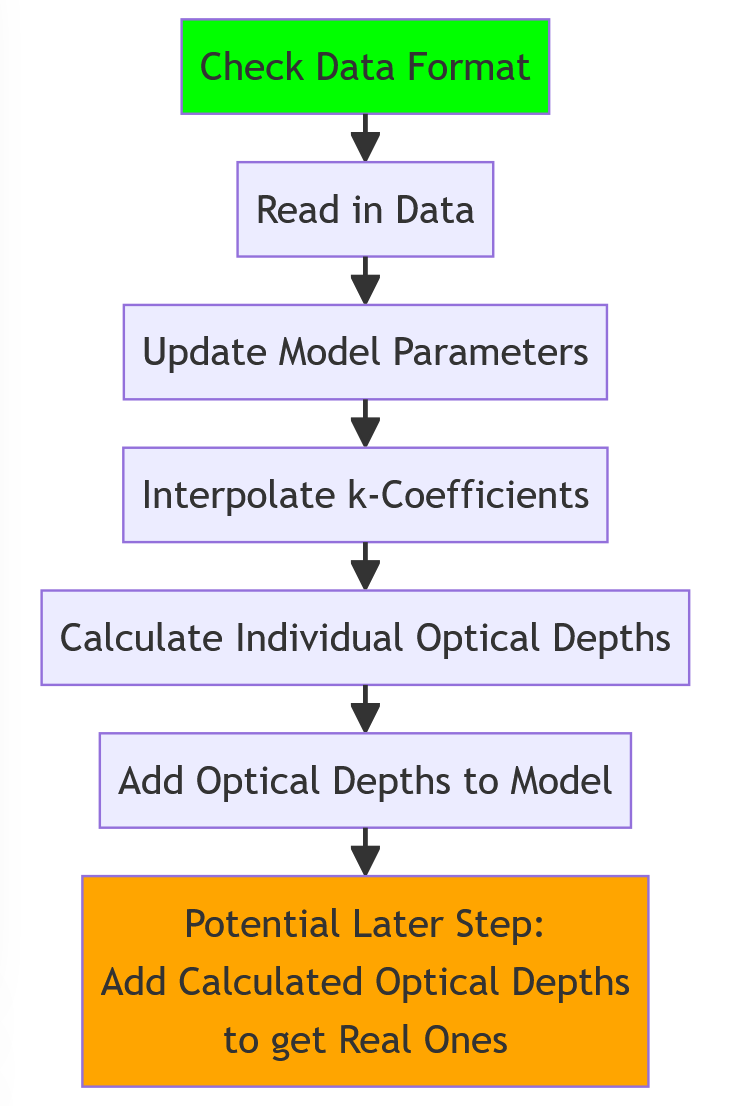

The orange step is one that likely happens elsewhere in the code, just somewhere we cannot see.

The three functions are `set_species()`, `interpolate_kc()`, and `append_kc_to_layers()`. In reality though, this is all one thing as `set_species()` calls both of the others in the process of running.

The overall goal of this code is to take in k-coefficients and use them to calculate the optical depth of a single gas species, and then store that optical depth in the "model." The "model" is mysterious as we don't have the full code here, but it appears to be an object much like the .npy file itself, essentially a map with lots of content, each of which can be entirely unique (or even be other objects with their own methods, in this case!) For understanding the code, all we care about it is that it stores our data in the end. The k-coefficients come from a .npy file, and the species is presumably entered manually, but the .npy file does have it in the title, if you want to extract it.

`set_species()` can handle three types of input, but only one is ours: the .npy file, so we shall ignore the other two options. Only after the check is performed is the file actually loaded properly, and then the "model" is updated with the wavelength values. Then we call `append_kc_to_layers` which just loads more information from the .npy to the "model". Then, for every layer in the "model" (presumably it came with layers pre-set), `interpolate_kc()` is called. It find the temperature and pressure values that bound the value in the atmosphere layer, and then linearly interpolates them. It's important to know that this is done in natural log space (for some reason) but I am unsure if this actually changes the final result at all or if it's just done for efficiency reasons. 

Regardless, once every layer has been interpolated, return up to `set_species()`. Now every layer has a k-coefficient. The optical depths are now calculated as `tau_species` and any NaNs that arise are dealt with. The optical depths are then added to the "model" and we're done. 

There may be some benefit to figuring out exactly what the calculation to get `tau_species` is. So... here it is.

$$ \tau_s = k_{s}N_s  $$

So the optical depth is the k-coefficient multiplied by a mysterious "N" we can't track down. However, we need to realize that we're not multiplying single elements, we're multiplying arrays--but not via matrix multiplication, we're using `*` which is element-based in numpy. Everything here is an array with other arrays in it. We don't have access to the N, but we do have access to the calculation of k via the interpolation functions. k in this equation is an array with on element for every atmosphere layer. However, each layer contains an interpolated k-coefficient for both every wavelength of light and every gauss order. This is likely done to make multiplication easy to write down. The N array is itself also of the length of the number of atmosphere layers. That said, we can't really say much about what it contains on the inside, besides it having to be of the same size of wavelengths x gauss orders. Naturally an optical depth for every wavelength is sensible. But every gauss order? The actual optical depth we're looking for would have to be a combination, but we're calculating each one individually. This implies that there's a later step we don't see where they are added together, perhaps hidden in the `update()` function for the model. (Which is presumably how it gets the gauss order weights needed to calculate everything in the first place, if that's even done ahead of time). I will investigate further in the bonus section and try to determine what exactly is in N.

The only reason we couldn't just use these functions as-is is because of the "model," which we do not know the inner workings of. I suppose we could work backward and construct an object that behaves the same, but why would we when we already have our setup with our own atmolayers? 

And that's everything I think is necessary to extract from all this. The notebook for generating more k-coefficients will not assist us as they are already generated. That's that!

# Bonus: Mathematical Messing 

## Just had to prove to myself that this was all reasonable

Quick: the mathematics is confirmed, though there are several ways to do what is shown in the code, and we do not have access to the "under the hood" implementation. This is fortunately not necessary to know, as gauss nodes and weights are independent of said implementation. 

Okay so I was curious as to what exactly was happening mathematically to get this result. From my correlated-k distribution notebook, I know the integral we are solving is:

$$ T_t = \int_0^1 e^{-\int_{z_1}^{z_2} k(g,P,T) \rho dz} dg $$

T is the transmission factor. This is equivalent to finding the optical depth, as $\tau = -ln T$. In our case we are interpolating to specific temperatures and pressures, so P and T are irrelevant. z is the position, and g is the cumulative distribution function which is only here because Fancy Mathematical Trick(tm). Since we are operating on small enough scales that P and T are irrelevant, we can pull k out of the upper integral and just use 'u' to represent the integration over density. (In fact the model atmosphere layer probably has this precalculated)

$$ T_t = \int_0^1 e^{- k(g) u} dg $$

Now what we're doing at this point is splitting this up into a Gaussian Quadrature, that is, calculating the integral as a sum instead. The exact specifics are unimportant, as this is an estimation method, but it becomes:

$$ T_t = \sum^n e^{- k(g_n) u} w_n $$

Where $g_n$ is the gaussian node, and $w_n$ is a weight for that point. These were provided by the .npy file above, as `g` and `w`. Anyway, if we apply the negative natural log to both sides...

$$ \tau_t = \sum^n  k(g_n) u - ln(w_n) $$

So, this tells us all we need to know about the actual implementation. When we calculate the $\tau$ in the code above, it's actually n ot complete. What we're calculating is a single part of $\tau$, one element of "n" in this equation--one for every guass order. We will need to add them all together to get the true optical depth. "u" clearly maps to "N" from the code. 

A question lingers: what of the natural log of the weight constant? It's not multiplied, it's subtracted. There are three potential solutions to this that are identical and depend on code implementation we cannot see: either the weight is folded into the constant "u" somehow, or it is applied later when the full optical depth is calculated in one final sum, or the integral to get transmission is recast as an integral to get optical depth and the weights are for that integral. 

If I were to do it, I'd note that u and $w_n$ are both constant for a given gaussian node n. Thus they are equivalent to creating a new constant N:

$$ T_t = \sum^n e^{- k(g_n) N_n} \Rightarrow \tau = \sum^n k(g_n) N_n$$

which may or may not be what the code actually does. So whether N is the "total amount of stuff" in the layer (u) or some combination constant is still unknown, but we have still extracted a method for actually using everything. Fortunately it does not matter what the "under the hood" implementation is, as it does not change the gauss nodes or weights, merely the form of the function. We should get the same answer either way, the k-coefficients do not change. 